# Lab 3

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import layers 
from keras import models
from keras import optimizers
from keras import models
from keras import layers
from sklearn import metrics
from keras import optimizers
from keras.applications import  InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Collecting a Dataset

1.You will collect a dataset from Kaggle. Register, it is free, and you will have access to lots of datasets.
Download the Flower corpus. You can find a local copy in the /usr/local/cs/EDAN95/datasets folder. Alternatively, you can use another dataset, provided that it has more than two categories. Tell your teacher in advance in this case to check if it is acceptable. You can use the Google dataset search: https://toolbox.google.com/datasetsearch.
2. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data.
3. To speed up the lab, you can also start with the partition available in the /usr/local/cs/EDAN95/datasets folder; or you can also use the code available from https://github.com/pnugues/edan95.



Splitting the dataset up into Test dataset (80%), validation dataset (20%) and Training dataset(20%) usin below code.

In [158]:
"""
Categorizing the flower dataset
Creating the dataset
Author: Pierre Nugues
"""

# The machine name
vilde = False

# To create the same dataset
random.seed(0)

# Here write the path to your dataset
if vilde:
    base = '/Users/madeleinejansson/'
else:
    base = '/Users/madeleinejansson/Documents/AppliedML/A3/flowers'
original_dataset_dir = os.path.join(base,'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])

random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']
2595
865
866


### Building a Simple Convolutional Neural Network

1. Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the ImageDataGenerator class to scale your images as in the book: 

- You will need to modify some parameters so that your network handles multiple classes.
- You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
- You will report the training and validation losses and accuracies and comment on the possible overfit.

2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.
3. Try to improve your model by modifying some parameters and evaluate your network again.



A quickly set up of Python generators that can automatically turn image files on disk into batches of preprocessed tensors. Using ImageDataGenerator to read images from directories

In [159]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# This is the directory where the training and validation data is stored
train_dir = '/Users/madeleinejansson/Documents/AppliedML/A3/flowers/flowers_split/train'
validation_dir = '/Users/madeleinejansson/Documents/AppliedML/A3/flowers/flowers_split/validation'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Creates a CNN with 4 convolutional layers and 4 maxpooling all in two dimension. To further fight overfitting, a Dropout layer has also been added to the model, right before the densely connected classifier.

In [162]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu')) # Added extra
#model.add(layers.MaxPooling2D((2, 2))) # Added extra
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(5, activation='softmax'))

Compile (configuring the model for training) and train the model. 


In [163]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit_generator( 
    train_generator, steps_per_epoch=130, epochs=20, validation_data=validation_generator, validation_steps=44)

Epoch 1/20
130/130 [==============================] - 142s 1s/step - loss: 1.3874 - acc: 0.3953 - val_loss: 1.1785 - val_acc: 0.4855
Epoch 2/20
130/130 [==============================] - 130s 999ms/step - loss: 1.1695 - acc: 0.5199 - val_loss: 1.2785 - val_acc: 0.5618
Epoch 3/20
130/130 [==============================] - 132s 1s/step - loss: 1.0719 - acc: 0.5634 - val_loss: 1.2090 - val_acc: 0.6092
Epoch 4/20
130/130 [==============================] - 154s 1s/step - loss: 1.0011 - acc: 0.6008 - val_loss: 1.0753 - val_acc: 0.5965
Epoch 5/20
130/130 [==============================] - 132s 1s/step - loss: 0.9435 - acc: 0.6240 - val_loss: 1.2150 - val_acc: 0.6324
Epoch 6/20
130/130 [==============================] - 129s 996ms/step - loss: 0.8918 - acc: 0.6502 - val_loss: 1.9835 - val_acc: 0.6277
Epoch 7/20
130/130 [==============================] - 153s 1s/step - loss: 0.8574 - acc: 0.6599 - val_loss: 2.1528 - val_acc: 0.6335
Epoch 8/20
130/130 [==============================] - 148s 1s/s

In [118]:
model.save('Flowers_small.h5')

Plotting the loss and accuracy of the model over the training and validation data during training.

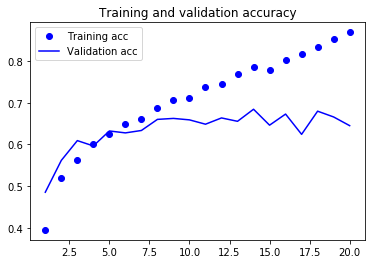

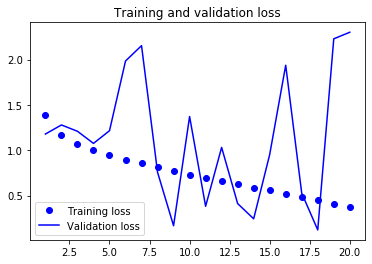

In [164]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Split the test data into readable digits.

In [165]:
test_dir = '/Users/madeleinejansson/Documents/AppliedML/A3/flowers/flowers_split/test'

test_generator = test_datagen.flow_from_directory(
        test_dir,
        shuffle = False,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


Found 865 images belonging to 5 classes.


Predicts the outcome

In [166]:
y_pred = model.predict_generator(test_generator, steps = 44)
y_pred = np.argmax(y_pred, axis = 1)

Evaluates the accuracy

In [1]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 44)
print('test_acc:', test_acc)

NameError: name 'model' is not defined

Classification report and confusion matrix

In [168]:
print('Classification report for classifier %s:\n%s\n'
     % (model, metrics.classification_report(test_generator.classes, y_pred)))
print('Confusion matrix: \n%s' % metrics.confusion_matrix(test_generator.classes, y_pred))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1b4d184810>:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       175
           1       0.81      0.63      0.71       203
           2       0.64      0.34      0.44       158
           3       0.66      0.89      0.76       140
           4       0.55      0.80      0.65       189

    accuracy                           0.67       865
   macro avg       0.69      0.67      0.66       865
weighted avg       0.69      0.67      0.66       865


Confusion matrix: 
[[124  11  11   9  20]
 [ 13 128   6  33  23]
 [ 14   8  54   6  76]
 [  3   5   2 125   5]
 [  5   6  12  15 151]]


### Using Image Augmentation

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: ImageDataGenerator. You will reuse it and apply it to the flower data set.

1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better. In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.
 
Setting up a data augmentation configuration via ImageDataGenerator

In [138]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)


Training the convnet using data-augmentation generators

In [139]:
test_datagen = ImageDataGenerator(rescale=1./255)

Train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fits the model

In [141]:
history = model.fit_generator(
      Train_generator,
      steps_per_epoch=130,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=44)

model.save('augmented_model.h5')

Epoch 1/20
130/130 [==============================] - 261s 2s/step - loss: 0.6860 - acc: 0.7555 - val_loss: 0.8885 - val_acc: 0.6208
Epoch 2/20
130/130 [==============================] - 251s 2s/step - loss: 0.6995 - acc: 0.7474 - val_loss: 0.6896 - val_acc: 0.6439
Epoch 3/20
130/130 [==============================] - 252s 2s/step - loss: 0.6612 - acc: 0.7559 - val_loss: 0.8217 - val_acc: 0.6347
Epoch 4/20
130/130 [==============================] - 265s 2s/step - loss: 0.6724 - acc: 0.7605 - val_loss: 4.1853 - val_acc: 0.6035
Epoch 5/20
130/130 [==============================] - 217s 2s/step - loss: 0.6647 - acc: 0.7628 - val_loss: 0.1735 - val_acc: 0.5434
Epoch 6/20
130/130 [==============================] - 216s 2s/step - loss: 0.6657 - acc: 0.7578 - val_loss: 0.0738 - val_acc: 0.6312
Epoch 7/20
130/130 [==============================] - 516s 4s/step - loss: 0.6808 - acc: 0.7509 - val_loss: 2.0255 - val_acc: 0.6312
Epoch 8/20
130/130 [==============================] - 233s 2s/step - 

Plots the result

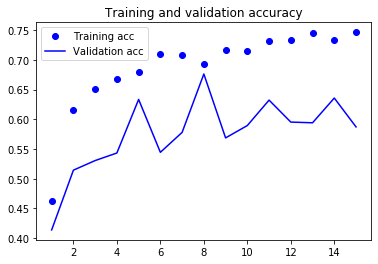

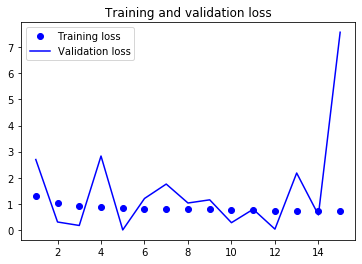

In [135]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Predicts the outcome

In [136]:
y_pred = model.predict_generator(test_generator, steps = 44)
y_pred = np.argmax(y_pred, axis = 1)

Evaluate the accuracy

In [137]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 44)
print('test_acc:', test_acc)

test_acc: 0.6208092570304871


Classification report and confusion matrix

In [92]:
print('Classification report for classifier %s:\n%s\n'
     % (model, metrics.classification_report(test_generator.classes, y_pred)))
print('Confusion matrix: \n%s' % metrics.confusion_matrix(test_generator.classes, y_pred))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1aaa29c210>:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       175
           1       0.78      0.77      0.77       203
           2       0.72      0.49      0.58       158
           3       0.77      0.81      0.79       140
           4       0.60      0.79      0.68       189

    accuracy                           0.72       865
   macro avg       0.73      0.71      0.71       865
weighted avg       0.72      0.72      0.71       865


Confusion matrix: 
[[123  14   9   7  22]
 [ 12 156   3  17  15]
 [ 15   9  77   3  54]
 [  4  13   1 113   9]
 [  6   9  17   7 150]]


### Using a Pretrained Convolutional Base

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments (http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.

1. Build a network that consists of the Inception V3 convolutional base and two dense layers. As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an extract_features() function.
2. Train your network and report the training and validation losses and accuracies.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.
4. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
5. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Instantiating the Inception V3 convolutional base.

In [49]:
 conv_base = InceptionV3(weights='imagenet', 
                        include_top=False, 
                        input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 106s 1us/step


In [ ]:
conv_base.summary()

Extracting features using the pretrained convolutional base.

In [50]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def extract_features(directory, sample_count): 
    features = np.zeros(shape = (sample_count, 3, 3, 2048)) 
    labels = np.zeros(shape = (sample_count,5)) 
    generator = datagen.flow_from_directory( directory, target_size = (150, 150), 
    batch_size = batch_size, class_mode = 'categorical') 
    i=0 
    for inputs_batch, labels_batch in generator: 
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1 
        if i * batch_size >= sample_count: 
            break 
    return features, labels


The extracted features are currently of shape (samples, 3, 3, 2048). We’ll feed them to a densely connected classifier, so first they needs to be flatten to (samples, 3\*3\*2048).

In [52]:
train_features, train_labels = extract_features(train_dir, 2593) 
validation_features, validation_labels = extract_features(validation_dir, 865) 
test_features, test_labels = extract_features(test_dir, 865)


train_features = np.reshape(train_features, (2593, 3*3*2048)) 
validation_features = np.reshape(validation_features, (865, 3*3*2048)) 
test_features = np.reshape(test_features, (865, 3*3*2048))


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Defining and training the densely connected classifier.

In [54]:
model = models.Sequential() 
model.add(layers.Dense(256, activation='relu', input_dim= 3*3 * 2048)) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, 
                    train_labels, 
                    epochs=30, 
                    batch_size=20, 
                    validation_data=(validation_features, validation_labels))


Train on 2593 samples, validate on 865 samples
Epoch 1/30
2593/2593 [==============================] - 24s 9ms/step - loss: 1.3599 - acc: 0.5492 - val_loss: 0.7236 - val_acc: 0.7514
Epoch 2/30
2593/2593 [==============================] - 21s 8ms/step - loss: 0.7793 - acc: 0.7158 - val_loss: 0.6930 - val_acc: 0.7468
Epoch 3/30
2593/2593 [==============================] - 20s 8ms/step - loss: 0.6096 - acc: 0.7829 - val_loss: 0.5812 - val_acc: 0.8035
Epoch 4/30
2593/2593 [==============================] - 22s 8ms/step - loss: 0.5101 - acc: 0.8184 - val_loss: 0.5616 - val_acc: 0.8058
Epoch 5/30
2593/2593 [==============================] - 25s 10ms/step - loss: 0.4052 - acc: 0.8612 - val_loss: 0.5674 - val_acc: 0.8012
Epoch 6/30
2593/2593 [==============================] - 21s 8ms/step - loss: 0.3485 - acc: 0.8797 - val_loss: 0.5737 - val_acc: 0.8058
Epoch 7/30
2593/2593 [==============================] - 20s 8ms/step - loss: 0.2890 - acc: 0.9028 - val_loss: 0.5755 - val_acc: 0.8092
Epoch 8

In [142]:
model.save('features_model.h5')

Plotting the results

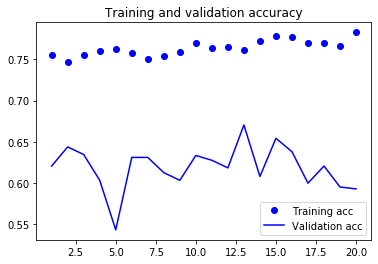

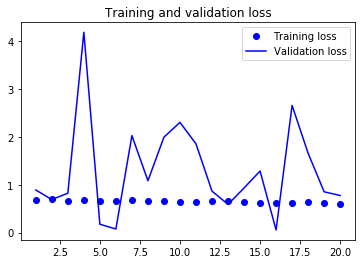

In [143]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Predicts the outcome

In [56]:
y_pred = model.predict(test_features)
Y_pred = np.argmax(y_pred, axis = 1)
Y_test = np.argmax(test_labels, axis = 1)

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 44)
print('test_acc:', test_acc)

Classification report and confusion matrix

In [57]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_test, Y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(Y_test, Y_pred))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1ae0b31b50>:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       175
           1       0.88      0.88      0.88       203
           2       0.86      0.78      0.82       158
           3       0.81      0.86      0.83       140
           4       0.78      0.88      0.83       189

    accuracy                           0.85       865
   macro avg       0.85      0.85      0.85       865
weighted avg       0.85      0.85      0.85       865


Confusion matrix:
[[145   9   3   6  12]
 [  6 179   3   9   6]
 [  1   3 124   7  23]
 [  3   8   4 120   5]
 [  1   4  11   7 166]]


In [145]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_107[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

Adding a densely connected classifier on top of the convolutional base. In Keras, you freeze a network by setting its trainable attribute to False.

In [157]:
model = models.Sequential()
model.add(conv_base)

model.add(layers.Conv2D(2048, (3, 3), activation='relu')) # Added extra

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

conv_base.trainable = False

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_230/convolution' (op: 'Conv2D') with input shapes: [?,1,1,2048], [3,3,2048,2048].

In [149]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 1, 1, 2048)        37750784  
Total params: 59,553,568
Trainable params: 37,750,784
Non-trainable params: 21,802,784
_________________________________________________________________


Training the model end to end with a frozen convolutional base

In [151]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Compile and fit the model

In [152]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=130,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=44)

model.save('conv_base_augmentation_model.h5')

Epoch 1/15
130/130 [==============================] - 620s 5s/step - loss: 1.2043 - acc: 0.5264 - val_loss: 2.6089 - val_acc: 0.5757
Epoch 2/15
130/130 [==============================] - 632s 5s/step - loss: 0.9584 - acc: 0.6456 - val_loss: 0.4454 - val_acc: 0.5468
Epoch 3/15
130/130 [==============================] - 593s 5s/step - loss: 0.9076 - acc: 0.6699 - val_loss: 0.8580 - val_acc: 0.6035
Epoch 4/15
130/130 [==============================] - 559s 4s/step - loss: 0.8470 - acc: 0.6888 - val_loss: 6.4743 - val_acc: 0.5503
Epoch 5/15
130/130 [==============================] - 560s 4s/step - loss: 0.8086 - acc: 0.6872 - val_loss: 0.9784 - val_acc: 0.4936
Epoch 6/15
130/130 [==============================] - 559s 4s/step - loss: 0.7755 - acc: 0.7081 - val_loss: 1.1344 - val_acc: 0.6000
Epoch 7/15
130/130 [==============================] - 559s 4s/step - loss: 0.7562 - acc: 0.7285 - val_loss: 3.3701 - val_acc: 0.5514
Epoch 8/15
130/130 [==============================] - 596s 5s/step - 

Plotting the results

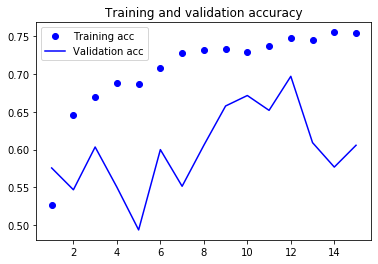

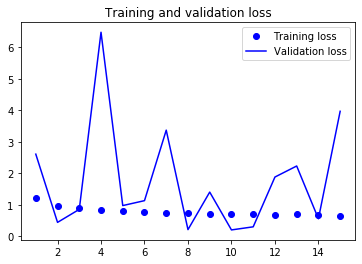

In [153]:
import matplotlib.pyplot as plt
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Predcits the outcome

In [154]:
y_pred = model.predict_generator(test_generator, steps=44)
Y_pred = np.argmax(y_pred, axis = 1)

Classification report and confusion matrix

In [155]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(test_generator.classes, Y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_generator.classes, Y_pred))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x1b03a81f10>:
              precision    recall  f1-score   support

           0       0.50      0.94      0.66       175
           1       0.83      0.45      0.59       203
           2       0.80      0.71      0.75       158
           3       0.57      0.57      0.57       140
           4       0.81      0.62      0.71       189

    accuracy                           0.66       865
   macro avg       0.70      0.66      0.65       865
weighted avg       0.71      0.66      0.65       865


Confusion matrix:
[[165   3   1   4   2]
 [ 77  92   1  28   5]
 [ 11   2 112  15  18]
 [ 47   6   5  80   2]
 [ 28   8  21  14 118]]
